# ARIMA Single Model

---

In [2]:
# DataFrame
import pandas as pd
import numpy as np
import random
from datetime import datetime, date

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

# Save the log
import os
import pickle
import time
from datetime import timedelta
# EEMD
from PyEMD import EEMD

# ARIMA
from pmdarima.arima import auto_arima

# Metric 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

In [3]:
# Minus
matplotlib.rcParams['axes.unicode_minus'] = False
# 한글
plt.rc('font', family='NanumGothic')

## Data Explore

In [4]:
df = pd.read_csv("../Data/All_capstone_df.csv")
df['Date'] = pd.to_datetime(df['Date'])

---

### Split the train and test set
- Input
     data: dataframe with dates and Demand data
     
- output
    - train: ~ 2012-06-30
    
    - test :  2022-07-01 ~ 2012-12-31

In [5]:
# train과 test로 데이터 split
def split_data(product_df):
    
    train_df = product_df[product_df['Date']<'2022-07-01'].reset_index(drop=True)
    test_df = product_df[product_df['Date']>='2022-07-01'].reset_index(drop=True)
    return train_df, test_df

## ARIMA
- Rolling forecast 방식으로 input값으로 테스트 기간의 값이 들어가서, 1일 후를 예측한 것을 총 6개월 이어붙임

In [6]:
# Rolling Forecasting
def ARIMA_single(product_df):

    train_df, test_df = split_data(product_df)
    features = product_df.drop(['y', 'Date','Product', '년월'], axis=1).columns.tolist()
    predictions = []
    best_model = auto_arima(train_df['y'], X=train_df[features],
                            start_p=1, start_q=1,
                            max_p=5, max_q=5, 
                            max_d=2, trace=True,
                            suppress_warnings=True)
    
    for test_date in test_df['Date']:
        print(test_date)
        
        test_date_prev_1 = test_date - pd.Timedelta(days=1)
        train_until_test_df = product_df[product_df['Date'] <= test_date_prev_1]
        
        best_model_fit = best_model.fit(train_until_test_df['y'], X=train_until_test_df[features])
        
        # Using exogenous variables of the day before the test date for prediction
        exog_for_pred = train_until_test_df[train_until_test_df['Date'] == test_date_prev_1][features].values.reshape(1, -1)
        prediction = best_model_fit.predict(n_periods=1, X=exog_for_pred).iloc[0]
    
        predictions.append(max(0, prediction))

    # Create a DataFrame to hold the result
    res_df = test_df.copy()
    res_df['Pred'] = predictions
    res_df.set_index('Date', inplace=True)

    # res_df: ['y'','Pred'] index='Date'
    return best_model, res_df

## Save & Load the model

In [7]:
def save_model(product_code, best_model):
    today = date.today()
    folder_path = 'Result/Single_ARIMA_Result/Model'
    file_name = f'{product_code}_{today.month:02d}{today.day:02d}.pkl'
    save_path = os.path.join(folder_path, file_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    # 객체를 pickle 파일로 저장
    with open(save_path, 'wb') as f:
        pickle.dump(best_model, f)
    return best_model

In [8]:
# 학습된 모델 pickle파일에서 불러오기
def load_model(file_name):
    file_path = f'Result/Single_ARIMA_Result/Model/{file_name}'
    
    with open(file_path, 'rb') as file:
        model_dict= pickle.load(file)
    
    return best_model

## Plot the result

In [9]:
def actual_pred_plot(product_code, res_df, metric_df):
    today = date.today()
    """
    Plot the actual vs predition and save the figure in the given directory
    """
    save_path = os.path.join("Result", "Single_ARIMA_Result", product_code)
    save_name = f'{product_code}_all_result'
    
    title = f"Pred Actual Plot - {product_code}"
    actual = res_df['y']
    pred = res_df['Pred']

    # Plot   
    plt.figure(figsize=(16, 8))
    plt.title(title, fontsize=20)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Order Demand", fontsize=14)
    plt.plot(actual, label ='Actual', color='r', marker='o', ms=3)
    plt.plot(pred, label='Prediction', color='b', marker='o', ms=3)
    plt.legend(loc="upper right")
        
    # Plot 결과 저장
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    # save the figure
    today_date = f'_{today.month:02d}{today.day:02d}'
    plt.savefig(os.path.join(save_path, save_name+'.png'))
    plt.show()
    
    # 전체 결과에 대한 Metric도 함께 저장
    metric_df.to_csv(os.path.join(save_path, save_name+'.csv'), encoding="utf-8-sig")
    res_df.to_csv(os.path.join(save_path, f'{product_code}_total_result.csv'), encoding="utf-8-sig")
    plt.close('all') # close all figures to free up memory

## Metrics

In [10]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / (actual+1)))

# 정규화 된 지표
def nrmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, squared=False)
    target_mean = np.mean(y_true)
    nrmse = mse / target_mean
    return nrmse

# 정규화 된 지표
def nmae(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    target_mean = np.mean(y_true)
    nmae = mae / target_mean
    return nmae

In [11]:
def calculate_metrics(product_code, res_df):

    actual = res_df['y']
    pred = res_df['Pred']

    # 메트릭 계산
    MAPE = mape(actual, pred) 
    RMSE = mean_squared_error(actual, pred)**0.5 
    MAE = mean_absolute_error(actual,pred) 
    NRMSE = nrmse(actual,pred) 
    NMAE = nmae(actual,pred) 
    R2 = r2_score(actual, pred)

    # 계산된 메트릭을 데이터프레임에 추가
    metric_df = pd.DataFrame({'MAPE':[round(MAPE, 4)],
                           'RMSE':[round(RMSE, 4)],
                           'MAE':[round(MAE, 4)],
                           'NRMSE':[round(NRMSE, 4)],
                           'NMAE':[round(NMAE, 4)],
                           'R2': [round(R2, 4)]},
                            index= [product_code])

    return metric_df

---

## Check the Result

In [12]:
def execute_single_ARIMA(product_code):
    start_time = time.time()
    
    product_code = product_code # 예측하고자 하는 코드 입력
    product_df = df[df['Product']== product_code].reset_index(drop=True)

    # Prophet 단일 모델
    best_model, res_df = ARIMA_single(product_df) 
    save_model(product_code, best_model)
    # 모델 Metric과 Pred_Actual Plot 저장
    metric_df= calculate_metrics(product_code, res_df)
    actual_pred_plot(product_code, res_df, metric_df)
    
    # 실행시간 확인
    elapsed_time_seconds = time.time() - start_time
    elapsed_time_minutes = elapsed_time_seconds / 60
    print("실행 시간: {:.2f} 분".format(elapsed_time_minutes))
    return metric_df

---

## Whole Process
    - product_code에 str으로 예측하고자 하는 코드를 입력

========== 2210 ==========
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=26785.658, Time=1.85 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=26824.951, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=26784.214, Time=1.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=26784.426, Time=1.93 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=26822.956, Time=2.08 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=26784.785, Time=1.60 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=26775.097, Time=2.61 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=26753.192, Time=1.57 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=26758.289, Time=0.79 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=26748.202, Time=2.32 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=26746.208, Time=0.83 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=26748.192, Time=1.03 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=26747.775, Time=7.31 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=26744.210, Time=0

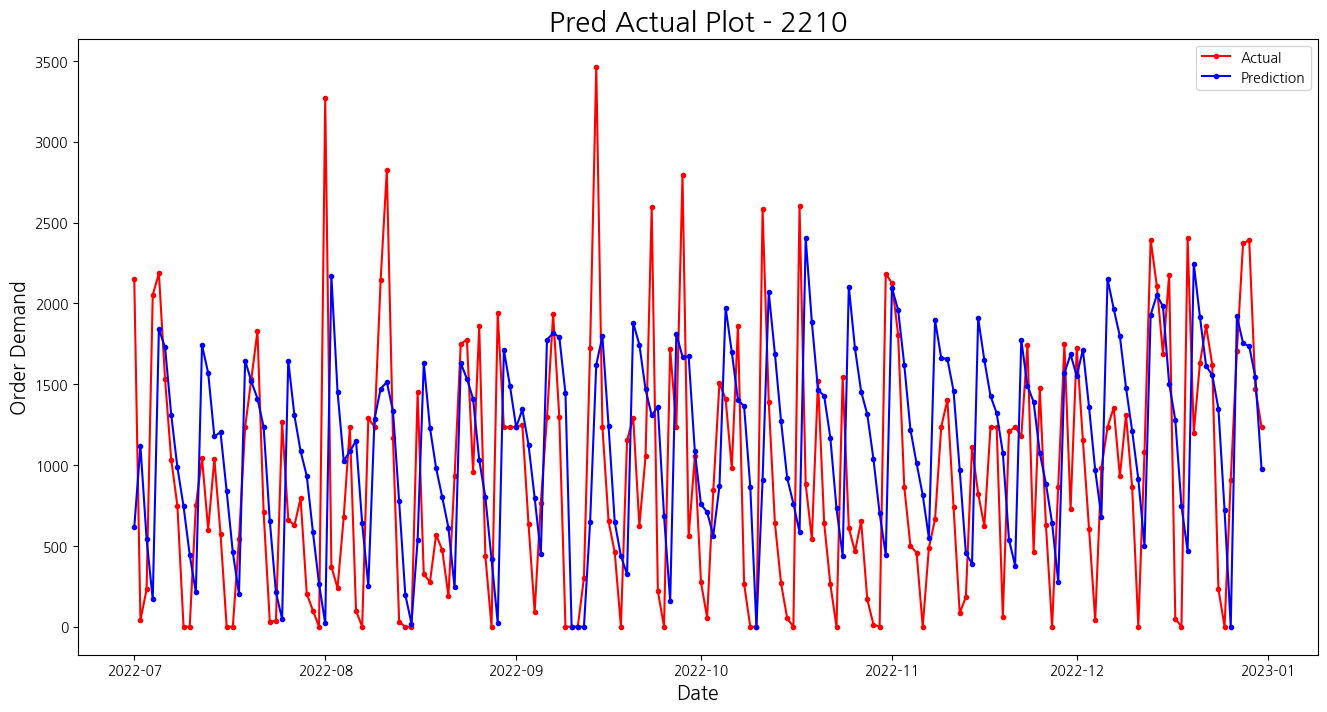

실행 시간: 2.69 분
========== 2213 ==========
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=27898.932, Time=2.68 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=27928.113, Time=0.28 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=27898.221, Time=1.70 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=27896.922, Time=2.89 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=27926.115, Time=2.20 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=27898.896, Time=2.25 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=27894.498, Time=2.23 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=6.84 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=27883.035, Time=2.10 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=27882.172, Time=2.18 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=27883.565, Time=1.22 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=27885.040, Time=2.55 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=27880.220, Time=0.67 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=27897.182

In [ ]:
all_metric = pd.DataFrame()

for code in ['2213.', '6190', '위너프페리']:
    print("==================================")
    print(f"========== { code } ==========")
    print("==================================")
    tmp_metric = execute_single_ARIMA(code)
    all_metric = pd.concat([all_metric, tmp_metric])